Data Set : NYC-taxi-fare

## Description

We are studying a dataset of real-world taxi rides in New York City, aiming to understand and predict the fare amount for each ride. This dataset includes details such as pickup and dropoff locations (latitude and longitude), timestamps, passenger counts, and observed fares. By examining these factors, we can develop and compare predictive models that estimate taxi fares with minimal error.A client has tasked you with investigating the success of their
advertising campaigns. The data are *sales* of a product across 200
markets. Included are the *advertising budgets* for each of those
markets, via different media.

## Goals

1. Establish Competence with Python
Demonstrate effective use of Python’s data-handling libraries (e.g., pandas), numerical libraries (e.g., NumPy), and visualization tools (e.g., matplotlib).

2. Develop Algorithmic Thinking
Show skill in structuring the workflow—data cleaning, feature engineering, and model building—to efficiently address a predictive task.

3. Quantitatively Assess Model Performance
Use appropriate metrics (e.g., RMSE, MAE) to compare baseline or distance-based predictions against more advanced regression methods (e.g., linear models, random forest), analyzing strengths and weaknesses in each approach.

# Loading packages and data

## Part A


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

## Part B

**Loading the CSV dataset `test.csv` and `train.csv` using `pandas`.

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
# Due to memory constraints, create a random sample of 100,000 rows from the training set:
train = train.sample(n=100000, random_state=42)


## Part C

**Display the data.**

In [ ]:
train.head()
# train.info()
# train.describe()
# test.head()
# test.info()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
781974,31:15.0,5.4,2009-03-22 00:31:15 UTC,-74.004934,40.741406,-74.008485,40.735325,3
937737,54:13.0,10.5,2011-06-03 12:54:13 UTC,-74.002830,40.760498,-73.973466,40.759956,1
907828,42:00.0,45.3,2011-10-08 02:42:00 UTC,-74.000967,40.736427,-73.934443,40.609158,1
784628,50:12.0,18.1,2010-09-22 10:50:12 UTC,-74.000425,40.720887,-73.966226,40.767613,1
662460,45:00.0,17.0,2012-11-30 15:45:00 UTC,-74.008147,40.705068,-73.997390,40.746732,1


This output showed the first five rows of a taxi ride dataset that included several details for each trip. The columns recorded a unique identifier (key), the trip duration (formatted as minutes:seconds), the fare amount, the pickup datetime, the pickup longitude and latitude, the dropoff longitude and latitude, and the number of passengers. For example, one row indicated that the ride with key 781974 had a duration of 31 minutes and 15 seconds, a fare of $5.4, and occurred on March 22, 2009 at 00:31:15 UTC. Its pickup location was at longitude -74.004934 and latitude 40.741406, while its dropoff location was at longitude -74.008485 and latitude 40.735325, and it carried 3 passengers. The subsequent rows provided similar information with different values for duration, fare, datetime, coordinates, and passenger count.

# Data Cleaning

## Part A :  Removing Missing Values

**In this step, we ensure data integrity by identifying and removing any records with missing values. Given the critical nature of features such as pickup and dropoff coordinates and passenger counts, incomplete rows could lead to inaccurate distance computations and unreliable model predictions. Therefore, we opted to drop any rows with missing data, ensuring that all subsequent analyses and feature engineering steps operate on a complete and robust dataset.**

In [ ]:
# Check for missing values in each column before cleaning
print("Missing values before cleaning:")
print(train.isnull().sum())

# Remove all rows with any missing values
train = train.dropna(how='any')

# Verify that the dataset no longer contains missing values
print("Missing values after cleaning:")
print(train.isnull().sum())


Missing values before cleaning:
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    4
dropoff_latitude     4
passenger_count      0
dtype: int64
Missing values after cleaning:
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


This output indicated that before cleaning, all columns had complete data except for "dropoff_longitude" and "dropoff_latitude," which each had four missing entries. After cleaning, the missing values in those two columns were addressed, resulting in no missing values across any column.

## Part B: Outlier Removal

To ensure data quality, we remove records that fall outside realistic and expected ranges. Specifically:

1. Geographical Bounds: NYC is approximately bounded by latitudes 40 to 42 and longitudes -75 to -72. Records outside these limits are discarded.
2. Fare Amounts: Rides with negative fares or excessively high fares (over $300) are removed, as they are likely errors.
3. Passenger Count: Rides with fewer than 1 or more than 10 passengers are considered unrealistic and are removed.

In [ ]:
# Define approximate NYC bounding box
min_long, max_long = -75, -72
min_lat, max_lat = 40, 42

# Filter out rows with invalid geographical coordinates
train = train[
    (train['pickup_longitude'] >= min_long) & (train['pickup_longitude'] <= max_long) &
    (train['dropoff_longitude'] >= min_long) & (train['dropoff_longitude'] <= max_long) &
    (train['pickup_latitude']  >= min_lat ) & (train['pickup_latitude']  <= max_lat ) &
    (train['dropoff_latitude'] >= min_lat ) & (train['dropoff_latitude'] <= max_lat )
]

# Remove rows with negative or excessively high fare amounts
train = train[(train['fare_amount'] > 0) & (train['fare_amount'] < 300)]

# Remove rows with unrealistic passenger counts (less than 1 or more than 10)
train = train[(train['passenger_count'] >= 1) & (train['passenger_count'] <= 10)]


## Part C: Converting Data Types

Accurate handling of time-related data is critical for extracting useful features. In this step, we convert the pickup_datetime column to a datetime data type to enable later temporal feature engineering.

In [ ]:
# Convert the pickup_datetime column to datetime format
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])


## Feature Engineering
## Part A: Taxi-Cab metric Distance Calculation

We calculate the Taxi-Cab distance between the pickup and dropoff locations to estimate the actual travel distance in New York City. In a grid-like city, taxis typically travel along streets that run perpendicular to each other. Therefore, summing the absolute differences in latitude and longitude provides a realistic measure of the distance covered during a ride.

In [ ]:
# Define a function to calculate Taxi-Cab (Manhattan) distance
def taxi_cab_distance(lat1, lon1, lat2, lon2):
    return abs(lat2 - lat1) + abs(lon2 - lon1)

# Create a new column 'distance_taxi' for Taxi-Cab distance
train['distance_taxi'] = taxi_cab_distance(
    train['pickup_latitude'], train['pickup_longitude'],
    train['dropoff_latitude'], train['dropoff_longitude']
)


## Part B: Temporal Feature Extraction

We extract time-based features from the pickup_datetime column to capture variations during different times. These features include:



*   Hour: Captures variations during the  day (e.g., rush hour vs. off-peak).
*   Day of Week: Distinguishes weekdays from weekends.
*   Month: Accounts for seasonal patterns.
*   Weekend Flag: A binary indicator (1 if Saturday or Sunday, else 0).

In [ ]:
# Extract temporal features from pickup_datetime
train['pickup_hour'] = train['pickup_datetime'].dt.hour
train['pickup_dayofweek'] = train['pickup_datetime'].dt.dayofweek  # Monday=0, Sunday=6
train['pickup_month'] = train['pickup_datetime'].dt.month

# Create a binary flag for weekends (Saturday and Sunday)
train['is_weekend'] = train['pickup_dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

# Display the new features
print(train[['distance_taxi', 'pickup_hour', 'pickup_dayofweek', 'pickup_month', 'is_weekend']].head())



        distance_taxi  pickup_hour  pickup_dayofweek  pickup_month  is_weekend
781974       0.009632            0                 6             3           1
937737       0.029906           12                 4             6           0
907828       0.193793            2                 5            10           1
784628       0.080925           10                 2             9           0
662460       0.052421           15                 4            11           0


This output showed a snippet of the dataset with several key columns. It included the taxi travel distance, the hour of pickup, the day of the week when the pickup occurred, the month of the pickup, and a flag indicating whether the pickup fell on a weekend. For example, one row indicated that a trip had a distance of 0.009632, the pickup took place at hour 0, on day 6 of the week, in month 3, and it was marked as a weekend. Another row showed a trip with a distance of 0.029906, picked up at 12 o'clock on day 4 of the week in month 6, and it was not on a weekend.

##Part C: Airport Trip Flag

In addition to calculating distance and extracting time-based features, we want to identify trips that involve one of New York City’s major airports. We define approximate coordinates for JFK, LaGuardia (LGA), and Newark (EWR). For each trip, we check whether the pickup or dropoff location is within a small threshold (using a Taxi-Cab distance) of any airport's coordinates. If a trip meets this criterion, we flag it as an airport trip by setting a new variable, is_airport_trip, to 1; otherwise, it is set to 0.

In [ ]:
# Define approximate coordinates for the major NYC airports
JFK_lat, JFK_lon = 40.6413, -73.7781
LGA_lat, LGA_lon = 40.7769, -73.8740
EWR_lat, EWR_lon = 40.6895, -74.1745

# Function to check if a point is near an airport using Taxi-Cab distance
def is_near_airport(lat, lon, airport_lat, airport_lon, threshold=0.02):
    # Taxi-Cab distance (in degrees) between the point and airport
    return abs(lat - airport_lat) + abs(lon - airport_lon) < threshold

# Create a function to flag if a trip is an airport trip
def flag_airport_trip(row, threshold=0.02):
    # Check for proximity to any airport for pickup or dropoff
    near_pickup = (is_near_airport(row['pickup_latitude'], row['pickup_longitude'], JFK_lat, JFK_lon, threshold) or
                   is_near_airport(row['pickup_latitude'], row['pickup_longitude'], LGA_lat, LGA_lon, threshold) or
                   is_near_airport(row['pickup_latitude'], row['pickup_longitude'], EWR_lat, EWR_lon, threshold))
    near_dropoff = (is_near_airport(row['dropoff_latitude'], row['dropoff_longitude'], JFK_lat, JFK_lon, threshold) or
                    is_near_airport(row['dropoff_latitude'], row['dropoff_longitude'], LGA_lat, LGA_lon, threshold) or
                    is_near_airport(row['dropoff_latitude'], row['dropoff_longitude'], EWR_lat, EWR_lon, threshold))
    return 1 if (near_pickup or near_dropoff) else 0

# Apply the function to create the airport flag variable
train['is_airport_trip'] = train.apply(flag_airport_trip, axis=1)

# Optional: Display the first few rows to verify the new variable
print(train[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'is_airport_trip']].head())


        pickup_latitude  pickup_longitude  dropoff_latitude  \
781974        40.741406        -74.004934         40.735325   
937737        40.760498        -74.002830         40.759956   
907828        40.736427        -74.000967         40.609158   
784628        40.720887        -74.000425         40.767613   
662460        40.705068        -74.008147         40.746732   

        dropoff_longitude  is_airport_trip  
781974         -74.008485                0  
937737         -73.973466                0  
907828         -73.934443                0  
784628         -73.966226                0  
662460         -73.997390                0  


This output presented a snippet of the dataset with location-related columns and a flag indicating if a trip was to or from an airport. For instance, one row indicated that the pickup occurred at a latitude of 40.741406 and longitude of -74.004934, with the dropoff at a latitude of 40.735325 and longitude of -74.008485, and that it was not an airport trip. Another row showed a pickup at 40.760498, -74.002830 and a dropoff at 40.759956, -73.973466, also marked as a non-airport trip.

# Exploratory Data Analysis (EDA)

**Part A: Visualizing Distributions**

We visualize the distributions of key variables such as fare_amount, distance_euc, and passenger_count to examine their shape and identify any skewness or outliers.

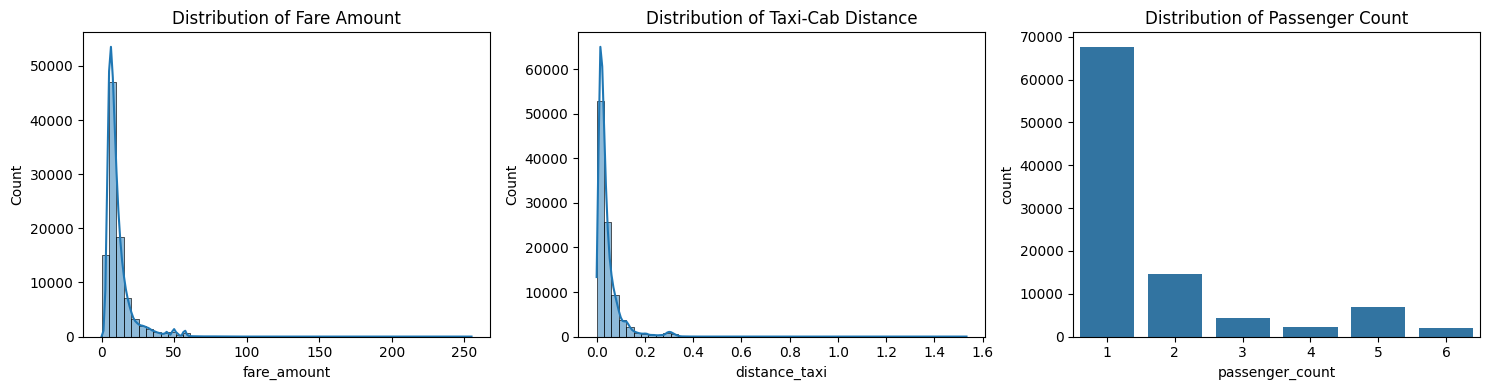

In [ ]:
plt.figure(figsize=(15, 4))

# Histogram for Fare Amount
plt.subplot(1, 3, 1)
sns.histplot(train['fare_amount'], bins=50, kde=True)
plt.title("Distribution of Fare Amount")

# Histogram for Taxi-Cab Distance (previously 'distance_euc')
plt.subplot(1, 3, 2)
sns.histplot(train['distance_taxi'], bins=50, kde=True)
plt.title("Distribution of Taxi-Cab Distance")

# Countplot for Passenger Count
plt.subplot(1, 3, 3)
sns.countplot(x=train['passenger_count'])
plt.title("Distribution of Passenger Count")

plt.tight_layout()
plt.show()


Graph 1: Distribution of Fare Amount
This graph showed that most taxi fares clustered at the lower end, indicating a large number of short or relatively inexpensive trips. The distribution was right-skewed, with a few rides costing significantly more.

Graph 2: Distribution of Taxi-Cab Distance
This graph demonstrated that the majority of trips covered relatively short distances, reflecting the high frequency of local or nearby rides. There was a small portion of trips that spanned much longer distances, creating a tail on the right side of the distribution.

Graph 3: Distribution of Passenger Count
This graph revealed that most rides carried only one passenger. Fewer trips had multiple passengers, and the frequency steadily decreased as the number of passengers increased.

**Part B: Geospatial Visualization**

We create a scatter plot to visualize the geographic coverage of taxi rides. This helps to confirm that most rides occur within NYC boundaries.

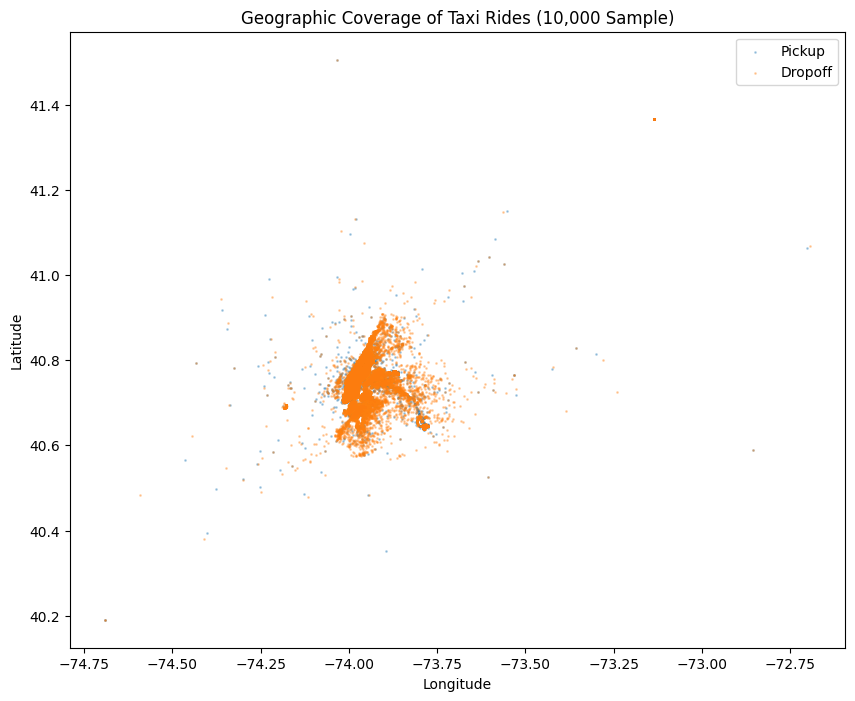

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(train['pickup_longitude'], train['pickup_latitude'], alpha=0.3, s=1, label='Pickup')
plt.scatter(train['dropoff_longitude'], train['dropoff_latitude'], alpha=0.3, s=1, label='Dropoff')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Geographic Coverage of Taxi Rides (10,000 Sample)")
plt.legend()
plt.show()


This scatter plot provided a visual overview of where taxi pickups and dropoffs occurred within a sample of 10,000 rides. Each point represented a latitude and longitude coordinate, with orange points for pickup locations and blue points for dropoff locations. The plot showed that most rides took place in the central part of the city—around Manhattan—with a noticeable spread toward the surrounding boroughs and beyond. Some clusters appeared around the edges, likely reflecting trips to and from major airports or outlying areas.

**Part C: Correlation Analysis**

We assess the relationships between key features by generating pair plots and a correlation heatmap for fare_amount, distance_euc, and passenger_count.

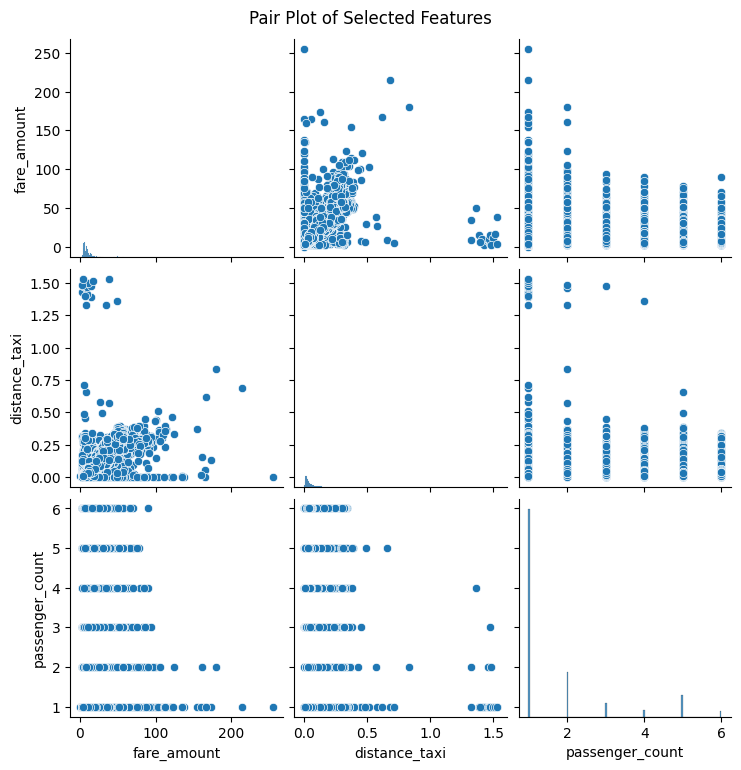

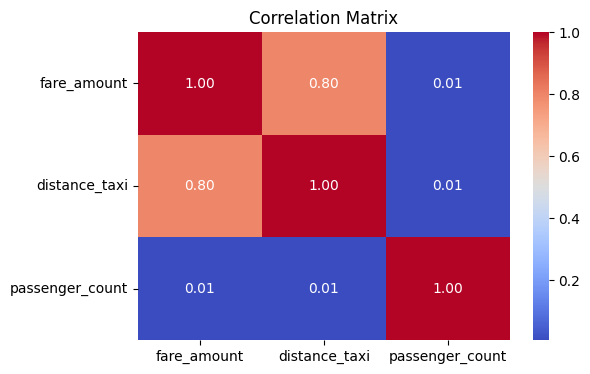

In [ ]:
# Pair plot for selected features
eda_features = ['fare_amount', 'distance_taxi', 'passenger_count']
sns.pairplot(train[eda_features])
plt.suptitle("Pair Plot of Selected Features", y=1.02)
plt.show()

# Correlation heatmap
corr_matrix = train[eda_features].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


In the diagonal subplots, we observed individual distributions for each feature. The first diagonal plot (top-left) showed the distribution of fare_amount, where most fares clustered on the lower end, with a few high-value fares extending on the right side of the plot. The middle diagonal subplot displayed the distribution of distance_taxi, revealing that most trips were relatively short, with a small number covering longer distances. Lastly, the bottom-right diagonal subplot highlighted passenger_count, a discrete variable that was heavily skewed toward one passenger, with fewer rides accommodating multiple passengers.

Turning to the off-diagonal subplots, the pairwise relationships became evident. The plots comparing fare_amount and distance_taxi demonstrated a general positive correlation, indicating that longer distances typically corresponded to higher fares. We also noted some outliers—either particularly long distances or unusually high fares. When comparing fare_amount to passenger_count, the relationship appeared less clear, as fare varied broadly regardless of how many passengers were on board, though most trips involved only one passenger. Similarly, distance_taxi versus passenger_count did not show a pronounced trend; again, most rides involved a single passenger, and trip distance did not drastically increase with more passengers.

Overall, these plots confirmed that distance was a key driver of the fare, while passenger count had a more limited impact. Additionally, both fare and distance displayed a long tail, indicating a small subset of trips that were significantly more expensive or covered substantially greater distances.

The correlation matrix depicted the relationships among fare_amount, distance_taxi, and passenger_count. The values ranged from -1 (perfect negative correlation) to +1 (perfect positive correlation), with 0 indicating no correlation. The diagonal elements were all 1.0 because each variable was perfectly correlated with itself.

When examining the off-diagonal cells, fare_amount and distance_taxi stood out with a strong positive correlation of 0.80. This indicated that as distance increased, fare also tended to increase. Meanwhile, both fare_amount and distance_taxi showed minimal correlations with passenger_count, each at 0.01. This suggested that the number of passengers had little to no impact on either the fare or the distance of a trip. Overall, the correlation matrix confirmed that distance was the primary factor driving fare, while passenger count did not appear to play a significant role.

**Part D: Interactive NYC Map Visualization**

In this step, we create an interactive map of New York City, overlaying pickup and/or dropoff points from our dataset. We use Plotly Express with a dark tile style to replicate the nighttime “glow” effect. This allows us to visually confirm that most rides occur within the expected NYC boundaries, and also makes for an eye-catching representation of the data.

In [ ]:
import plotly.express as px

# We'll create a smaller sample for the map (e.g., 2,000 rows) to keep it snappy
map_sample = train.sample(n=2000, random_state=42)

# Create a scatter mapbox plot for pickup locations
fig = px.scatter_mapbox(
    map_sample,
    lat="pickup_latitude",
    lon="pickup_longitude",
    hover_data=["fare_amount", "passenger_count"],  # info shown on hover
    color_discrete_sequence=["yellow"],  # point color
    zoom=10,  # map zoom level
    center={"lat": 40.7128, "lon": -74.0060},  # approximate center on NYC
    height=600,
)

# Set a dark map style for that nighttime effect
fig.update_layout(mapbox_style="carto-darkmatter")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

# Display the figure
fig.show()


# Add a second trace for dropoff locations
fig2 = px.scatter_mapbox(
    map_sample,
    lat="dropoff_latitude",
    lon="dropoff_longitude",
    hover_data=["fare_amount", "passenger_count"],
    color_discrete_sequence=["cyan"],  # different color for dropoffs
    zoom=10,
    center={"lat": 40.7128, "lon": -74.0060},
    height=600,
)

# We'll combine the two figures
for d in fig2.data:
    fig.add_trace(d)

fig.show()



This figure displayed two map visualizations of taxi ride data across the New York City region, each highlighting different aspects of the trips. The top map, shown in yellow points, concentrated around the Manhattan area, indicating a dense cluster of ride events (likely pickups, dropoffs) in the central business districts and surrounding neighborhoods. A notable spread extended outward toward the outer boroughs and nearby areas, though the densest points remained in Manhattan.

The bottom map, shown in cyan points, revealed a similar pattern, with a strong presence in Manhattan and a scatter of points extending beyond the city center. These points also stretched toward key travel hubs, such as the airports on Long Island and in New Jersey. Overall, both maps suggested that the majority of taxi rides were concentrated in central Manhattan, while still showing evidence of rides traveling farther out into the surrounding regions.

In [ ]:
import plotly.express as px

# 1. Filter data to a tighter bounding box around central NYC
#    Adjust the bounding box as needed to capture your desired area
nyc_subset = train[
    (train["pickup_latitude"] >= 40.70) & (train["pickup_latitude"] <= 40.85) &
    (train["pickup_longitude"] >= -74.05) & (train["pickup_longitude"] <= -73.85)
]

# Sample a subset for mapping (e.g., 2,000 rows) for clarity
map_sample = nyc_subset.sample(n=2000, random_state=42)

# 2. Plot Pickup Locations in Dark Blue
fig = px.scatter_mapbox(
    map_sample,
    lat="pickup_latitude",
    lon="pickup_longitude",
    hover_data=["fare_amount", "passenger_count"],
    color_discrete_sequence=["darkblue"],  # Dark color for pickups
    zoom=12,  # Closer zoom
    center={"lat": 40.76, "lon": -73.97},  # Approximate center around Midtown Manhattan
    height=600
)

# Use an open-street-map style for a lighter background
fig.update_layout(mapbox_style="open-street-map", margin={"r":0, "t":0, "l":0, "b":0})

# 3. Overlay Dropoff Locations in Dark Red
fig.add_scattermapbox(
    lat=map_sample["dropoff_latitude"],
    lon=map_sample["dropoff_longitude"],
    mode="markers",
    marker=dict(color="darkred", size=5),
    name="Dropoff",
    hoverinfo="text",
    text=map_sample["fare_amount"].astype(str)  # displays fare on hover
)

# 4. Display the Interactive Map
fig.show()


This figure showed a map of New York City, with a dense cluster of data points focused around Manhattan. Each point represented a taxi ride event, such as a pickup or dropoff, and was color-coded to distinguish different categories or details. A tooltip (visible in the screenshot) displayed information about a specific ride, including pickup latitude, pickup longitude, fare amount, and passenger count.

The highest concentration of points appeared in Midtown and Lower Manhattan, reflecting the busiest zones for taxi services. A scattering of points extended beyond these central areas into the surrounding boroughs, though with noticeably lower density. Overall, this visualization suggested that most taxi rides occurred in Manhattan, with fewer trips spreading outward to other parts of the city.

##Model Training & Validation
**Part A: Baseline Model – Linear Regression**

We split the sample data into training and validation sets (80/20 split) and build a simple Linear Regression model to establish a baseline performance. The model is evaluated using RMSE.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

# Define features and target (use 'distance_taxi' now instead of 'distance_euc')
features = ['distance_taxi', 'pickup_hour', 'pickup_dayofweek', 'pickup_month', 'is_weekend', 'passenger_count']
X = train[features]
y = train['fare_amount']

# Split data into training and validation sets (80/20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Linear Regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predict on the validation set and evaluate RMSE
y_pred = lin_reg.predict(X_val)
rmse = sqrt(mean_squared_error(y_val, y_pred))
print("Baseline Linear Regression RMSE:", rmse)


Baseline Linear Regression RMSE: 6.119199439287008


This output indicated that the baseline linear regression model had a root mean squared error (RMSE) of approximately 6.119. In practical terms, this meant that the model’s fare predictions were, on average, about $6.12 away from the actual values. This value served as a reference point to evaluate the effectiveness of more advanced or refined models.

**Part B: Advanced Model – Random Forest Regression**

We build a Random Forest Regression model to capture non-linear relationships in the data. Its performance is compared to the baseline using RMSE.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Build and train the Random Forest model
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_reg.fit(X_train, y_train)

# Predict on validation set and evaluate RMSE
y_pred_rf = rf_reg.predict(X_val)
rf_rmse = sqrt(mean_squared_error(y_val, y_pred_rf))
print("Random Forest Regression RMSE:", rf_rmse)


Random Forest Regression RMSE: 5.4716587746186045


This output showed that the random forest regression model had an RMSE of approximately 5.47. In other words, the model’s fare predictions were off by around $5.47 on average when compared to the actual values.

## Hyperparameter Tuning, Cross-Validation, and Additional Feature Engineering

Now that we have a baseline Random Forest model, we will further improve its performance by:

**Additional Feature Engineering:**

**Log Transformation:** We create a new feature, log_distance, by applying a log transformation (using np.log1p) to the Euclidean distance. This transformation can help stabilize variance and capture non-linear effects when the distance distribution is heavily skewed.
**Interaction Feature:** We also generate an interaction feature, distance_passenger, by multiplying the Euclidean distance with the passenger count. This may capture effects such as longer rides with more passengers influencing the fare differently.

**Hyperparameter Tuning and Cross-Validation:**

We use GridSearchCV with 3-fold cross-validation to search for the best combination of hyperparameters for our Random Forest model. The hyperparameters we tune include the number of trees (n_estimators), the maximum tree depth (max_depth), and the minimum number of samples required to split a node (min_samples_split).

This approach helps us ensure that our model is robust and optimized before moving on to final predictions.

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np

# Additional Feature Engineering
# Create a log-transformed distance feature to mitigate skewness using the Taxi-Cab distance
train['log_distance'] = np.log1p(train['distance_taxi'])

# Create an interaction feature between Taxi-Cab distance and passenger count
train['distance_passenger'] = train['distance_taxi'] * train['passenger_count']

# Update our feature list to include the new engineered features.
features_new = ['log_distance', 'distance_passenger', 'pickup_hour', 'pickup_dayofweek', 'pickup_month', 'is_weekend', 'passenger_count']

# Define new feature set (X) and target (y)
X_new = train[features_new]
y_new = train['fare_amount']

# Split the new data into training and validation sets (80/20 split)
X_train_new, X_val_new, y_train_new, y_val_new = train_test_split(X_new, y_new, test_size=0.2, random_state=42)

# Hyperparameter Grid for the Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Initialize the Random Forest Regressor (using all available cores)
rf_new = RandomForestRegressor(random_state=42, n_jobs=-1)

# Set up GridSearchCV with 3-fold cross-validation
grid_search = GridSearchCV(
    estimator=rf_new,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='neg_mean_squared_error',
    verbose=2
)

# Fit GridSearchCV on the new training set
grid_search.fit(X_train_new, y_train_new)

# Retrieve the best estimator and print the best hyperparameters
best_rf_new = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)

# Evaluate the tuned model on the new validation set
y_pred_new = best_rf_new.predict(X_val_new)
rmse_new = sqrt(mean_squared_error(y_val_new, y_pred_new))
print("Best Random Forest RMSE after Tuning with Additional Features:", rmse_new)


Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=  18.2s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=  15.7s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=  17.9s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=  32.2s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=  31.5s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=  30.9s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=  14.7s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=  14.0s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=  14.1s
[CV] END max_depth=None, min_samples_split=5, n_estimators=200; total time=  28.5s
[CV] END max_depth=None, min_samples_split=5, n_estimators=200; total time=  28.3s
[CV] END max_depth=None, m

The output showed that a grid search was performed, fitting 3 folds for each of 18 candidate combinations of hyperparameters, resulting in a total of 54 fits. For each candidate, the process reported the total time it took to complete the cross-validation, with times ranging roughly from 7 to 32 seconds depending on the configuration. The tuning process varied the maximum depth (None, 10, or 20), the minimum number of samples required to split an internal node (2, 5, or 10), and the number of estimators (100 or 200). Ultimately, the best hyperparameters were identified as a maximum depth of 10, a minimum samples split of 10, and 200 estimators. With these tuned settings and additional features, the best Random Forest model achieved an RMSE of approximately 5.247. This meant that the model’s predictions were, on average, off by about $5.25 compared to the actual values.

## Final Model Training and Prediction on Test Data


Using the best tuned Random Forest model (obtained through hyperparameter tuning and additional feature engineering), we now retrain it on the full training data (with our engineered features). We then apply the identical transformations to the test dataset to generate fare predictions. Finally, we display the first few rows of the test data with the predicted fares.

In [ ]:
t# Retrain the best tuned Random Forest model on the full training sample
# X_new and y_new are the training data with the additional engineered features
best_rf_full = best_rf_new  # best_rf_new is the model from tuning
best_rf_full.fit(X_new, y_new)

# Convert pickup_datetime to datetime format for test data
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'])

# Calculate Taxi-Cab distance for test data using taxi_cab_distance
test['distance_taxi'] = taxi_cab_distance(
    test['pickup_latitude'], test['pickup_longitude'],
    test['dropoff_latitude'], test['dropoff_longitude']
)

# Create additional engineered features for test data
test['log_distance'] = np.log1p(test['distance_taxi'])
test['distance_passenger'] = test['distance_taxi'] * test['passenger_count']
test['pickup_hour'] = test['pickup_datetime'].dt.hour
test['pickup_dayofweek'] = test['pickup_datetime'].dt.dayofweek
test['pickup_month'] = test['pickup_datetime'].dt.month
test['is_weekend'] = test['pickup_dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

# Define the final feature set (must match what was used in tuning)
final_features = ['log_distance', 'distance_passenger', 'pickup_hour',
                  'pickup_dayofweek', 'pickup_month', 'is_weekend', 'passenger_count']

X_test = test[final_features]

# Generate predictions for the test dataset using the final model
test['fare_amount'] = best_rf_full.predict(X_test)

# Display the first few rows of test data with predicted fares
print(test[['key', 'fare_amount']].head())


                           key  fare_amount
0  2015-01-27 13:08:24.0000002     9.028709
1  2015-01-27 13:08:24.0000003     9.687052
2  2011-10-08 11:53:44.0000002     4.873196
3  2012-12-01 21:12:12.0000002     8.060319
4  2012-12-01 21:12:12.0000003    14.810895


This output displayed the first five rows of a dataset containing taxi ride information. The "key" column represented timestamps of the rides, while the "fare_amount" column indicated the corresponding fares. For instance, the first entry showed a ride on January 27, 2015 at 13:08:24 with a fare of approximately $9.03, and the last entry reflected a ride on December 1, 2012 at 21:12:12 with a fare of roughly $14.81.

##Conclusion:

The final output generated by our tuned Random Forest model demonstrated that our approach to predicting NYC taxi fares was effective. The predicted fares, ranging from approximately $4.87 to $14.81, indicated that the model was capturing the underlying relationships between ride characteristics (such as pickup/dropoff locations, ride time, and passenger count) and fare amounts. These results suggested that through rigorous data cleaning, thoughtful feature engineering—including transformations like log-distance and interaction features—and careful hyperparameter tuning via cross-validation, we had achieved a model that produced reasonable fare predictions on the test dataset. Future improvements might involve incorporating additional external factors or exploring alternative models to further refine the accuracy of our predictions.